In [5]:
from IPython.display import clear_output

import numpy as np
import casadi
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation

clear_output()

In [6]:
# Inverted pendulum parameters
g = 9.81 # Gravitational acceleration
M = 1 # Cart mass
m =0.2 # Pendulum mass
l = 1 # Pendulum Length

nu = 1 # Control variable dimensions
nx = 4 # state variable dimentsions

# Cost function weights
Q = casadi.diag([2.5, 10, 0.01, 0.01])
R = casadi.diag([0.1])

# Prediction horizon etc.
T = 1
K = 20
dt = T/K

# Constraints
x_lb = [-np.inf, -np.inf, -np.inf, -np.inf]
x_ub = [np.inf, np.inf, np.inf, np.inf]
u_lb = [-15]
u_ub = [15]

# Target value
x_ref = casadi.DM([0, 0, 0, 0])
u_ref = casadi.DM([0])

total = nx*(K+1) + nu*K

In [ ]:
# states, ctrls가 주어지면 states dot을 구하는 함수
def make_f():
    states = casadi.SX.sym('states', nx)
    ctrls = casadi.SX.sym('ctrls', nu)

    x = states[0]
    theta = states[1]
    x_dot = states[2]
    theta_dot = states[3]
    F = ctrls[0]

    sin = casadi.sin(theta)
    cos = casadi.cos(theta)
    det = M+m*sin**2

    x_ddot = (m*sin*(l*theta_dot**2 - g*cos) + F)/det
    theta_ddot = (-m*l*theta_dot**2*sin*cos + (M+m)*g*sin -F*cos)/(l*det)

    states_dot = casadi.vertcat(x_dot, theta_dot, x_ddot, theta_ddot)

    f = casadi.Function('f', [states, ctrls], [states_dot], ['x', 'u'], ['x_dot'])
    return f

# Runge-kutta 4차 방법 기반의 상태 전이 함수
# 즉 hat x_k+1 = f_rk4(x, u)
# MPC 예측 모델
def make_F_RK4():
    states = casadi.SX.sym('states', nx)
    ctrls = casadi.SX.sym('ctrls', nu)

    f = make_f()

    k1 = f(x=states, u=ctrls)['x_dot']
    k2 = f(x=states+dt*k1/2, u=ctrls)['x_dot']
    k3 = f(x=states+dt*k2/2, u=ctrls)['x_dot']
    k4 = f(x=states+dt*k3, u=ctrls)['x_dot']

    states_next = states + 1/6*dt*(k1+2*k2+2*k3+k4)

    F_RK4 = casadi.Function('F_RK4', [states, ctrls], [states_next], ['x', 'u'], ['x_next'])
    return F_RK4

# plant 모델 (실제 시스템)
def make_integrator():
    states = casadi.SX.sym('states', nx)
    ctrls = casadi.SX.sym('ctrls', nu)

    f = make_f()
    ode = f(x=states, u=ctrls)['x_dot']
    dae = {'x': states, 'p': ctrls, 'ode': ode}
    I = casadi.integrator('I', 'cvodes', dae, 0, dt)
    return I


In [20]:
x1 = casadi.DM([1, casadi.pi/6, 0.001, 0.01])
u1 = casadi.DM([2])
f = make_f()
res = f(x=x1, u=u1)["x_dot"]
print(res)

F_RK4 = make_F_RK4()
res1 = F_RK4(x=x1, u=u1)["x_next"]
print(res1)

I = make_integrator()
xf = I(x0=x1, p=u1)["xf"]
print(xf)

[0.001, 0.01, 1.09566, 3.95613]
[1.00142, 0.529056, 0.0557499, 0.208693]
[1.00142, 0.529057, 0.0557496, 0.208694]


## Optimization Problem

$$
min_{X, U}  J = \sum_{k=0}^{K-1} stage\_cost(x_k, u_k) \cdot dt + terminal\_cost(x_K)
$$

subject to
$$
x_{k+1} = F_{RK4}(x_k, u_k)
$$

In [22]:
def compute_stage_cost(x, u):
    x_diff = x - x_ref
    u_diff = u - u_ref
    cost = (casadi.dot(x_diff, Q@x_diff) + casadi.dot(u_diff, R@u_diff)) / 2
    return cost

def compute_terminal_cost(x):
    x_diff = x - x_ref
    cost = casadi.dot(Q@x_diff, x_diff) / 2
    return cost

In [14]:
def make_nlp():
    F_RK4 = make_F_RK4()

    U = [casadi.SX.sym(f'u_{k}', nu) for k in range(K)]
    X = [casadi.SX.sym(f'x_{k}', nx) for k in range(K+1)]
    G = []

    J = 0

    for k in range(K):
        J += compute_stage_cost(X[k], U[k]) * dt
        eq = X[k+1] - F_RK4(x=X[k], u=U[k])["x_next"]
        G.append(eq)

    J += compute_terminal_cost(X[-1])

    option = {'print_time':False, 'ipopt': {'max_iter':10, 'print_level':0}}
    nlp = {"x":casadi.vertcat(*X, *U), "f":J, "g":casadi.vertcat(*G)}
    S = casadi.nlpsol("S", "ipopt", nlp, option)
    return S

Control Input Calculation

In [15]:
def compute_optimal_control(S, x_init, x0):
    x_init = x_init.full().ravel().tolist() # casadi symbol -> python list

    lbx = x_init + x_lb*K + u_lb*K
    ubx = x_init + x_ub*K + u_ub*K
    lbg = [0]*nx*K
    ubg = [0]*nx*K

    res = S(lbx=lbx, ubx=ubx, lbg=lbg, ubg=ubg, x0=x0)

    offset = nx*(K+1)
    x0 = res["x"]
    u_opt = x0[offset:offset+nu]
    return u_opt, x0

MPC

In [24]:
S = make_nlp()

t_span = [0, 10]
t_eval = np.arange(*t_span, dt)

x_init = casadi.DM([0, np.pi, 0,0])
x0 = casadi.DM.zeros(total)

I = make_integrator()

X = [x_init]
U = []
x_current = x_init
for t in t_eval:
    u_opt, x0 = compute_optimal_control(S, x_current, x0)
    x_current = I(x0=x_current, p=u_opt)["xf"]
    X.append(x_current)
    U.append(u_opt)



Visualizing the results

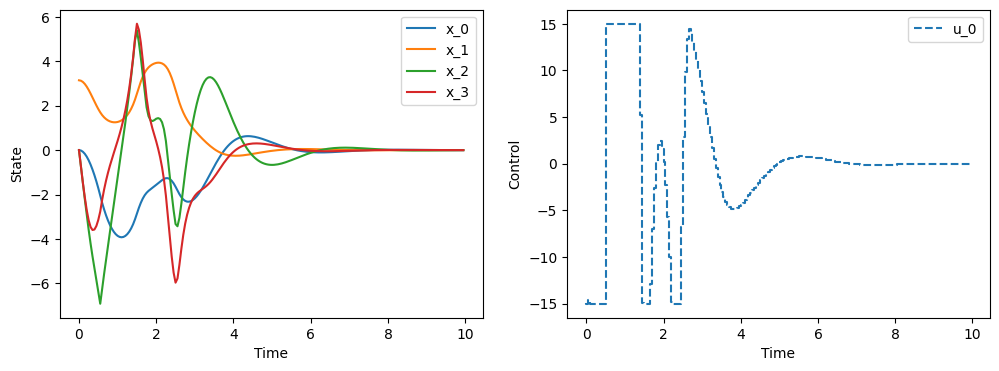

In [25]:
X.pop()
X = np.array(X).reshape(t_eval.size, nx)
U = np.array(U).reshape(t_eval.size, nu)

plt.figure(figsize=(12, 4))

plt.subplot(1,2,1)
for k in range(nx):
    plt.plot(t_eval, X[:,k], label=f"x_{k}")
plt.legend()
plt.xlabel("Time")
plt.ylabel("State")

plt.subplot(1,2,2)
for k in range(nu):
    plt.step(t_eval, U[:,k], linestyle="--", label=f"u_{k}")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Control")

plt.show()

Creatubg animations

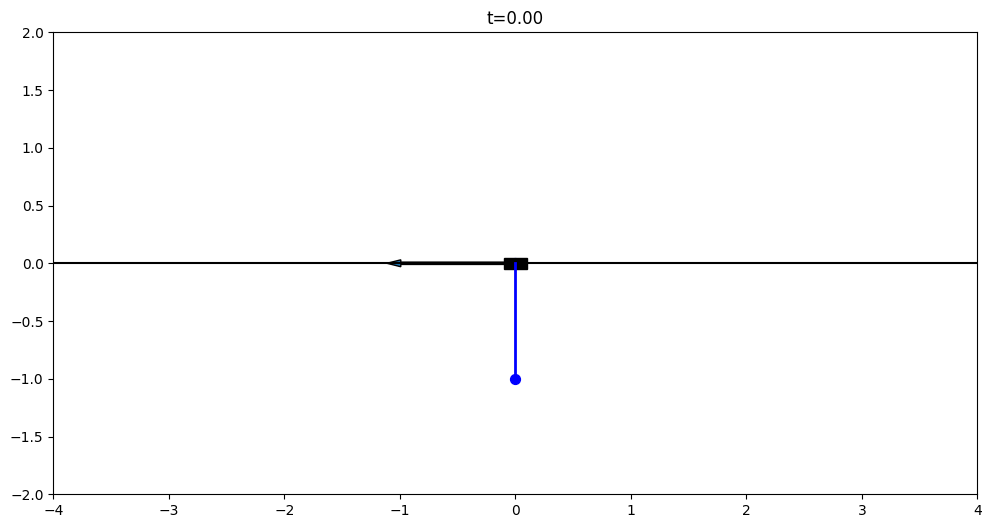

In [18]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
frames = np.arange(0, t_eval.size)
fps = 1 / dt

def update_figure(i):
    x_lim_min = -4
    x_lim_max = 4
    y_lim_min = -2
    y_lim_max = 2
    u_scale = 15

    ax.cla()
    ax.set_xlim(x_lim_min, x_lim_max)
    ax.set_ylim(y_lim_min, y_lim_max)
    ax.set_aspect("equal")
    ax.set_title(f"t={t_eval[i]:0.2f}")

    x, theta, _, _ = X[i]
    u, = U[i]

    # 막대 끝
    points = np.array([
        [x,x-l*np.sin(theta)],
        [0,l*np.cos(theta)]
    ])

    ax.hlines(0, x_lim_min, x_lim_max, colors="black")
    ax.scatter(*points, color="blue", s=50)
    ax.plot(*points, color='blue', lw=2)
    ax.arrow(x, 0, u/u_scale, 0, width=0.02, head_width=0.06, head_length=0.12)

    w=0.2
    h=0.1
    rect = patches.Rectangle(xy=(x-w/2, -h/2), width=w, height=h, color="black")
    ax.add_patch(rect)

ani = FuncAnimation(fig, update_figure, frames=frames)
ani.save("cart_pole.gif", writer="pillow", fps=fps)